# Objective 1: DICOM loading and visualization

In [1]:
#Import Libraries
import numpy as np
import scipy
from matplotlib import pyplot as plt, animation
import matplotlib
import pydicom
import os
import matplotlib
from PIL import Image
from scipy.optimize import least_squares
import math

Useful functions from the lab

In [36]:
def median_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median sagittal plane of the CT image provided. """
    return img_dcm[:, :, img_dcm.shape[1]//2]   


def median_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median sagittal plane of the CT image provided. """
    return img_dcm[:, img_dcm.shape[2]//2, :]


def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    return np.max(img_dcm, axis=2)


def AIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the average intensity projection on the sagittal orientation. """
    return np.mean(img_dcm, axis=2)


def MIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the coronal orientation. """
    return np.max(img_dcm, axis=1)


def AIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the average intensity projection on the coronal orientation. """
    return np.mean(img_dcm, axis=1)


def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

def find_centroid(mask: np.ndarray) -> np.ndarray:
    # Your code here:
    #   Consider using `np.where` to find the indices of the voxels in the mask
    #   ...
    idcs = np.where(mask == 1)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid

def visualize_axial_slice(img: np.ndarray, mask: np.ndarray, mask_centroid: np.ndarray) -> np.ndarray:
    """ Visualize the axial slice (first dimension) of a single region with alpha fusion. """
    fused_slices = []
    
    for i in range(img.shape[0]):
        cmap = plt.get_cmap('bone')
        norm = plt.Normalize(vmin=np.amin(img[i]), vmax=np.amax(img[i]))
        
        fused_slice = (
            0.75 * cmap(norm(img[i]))[..., :3] +
            0.25 * np.stack([mask[i], np.zeros_like(mask[i]), np.zeros_like(mask[i])], axis=-1)
        )
        
        fused_slices.append(fused_slice[..., 0])
    
    return np.array(fused_slices)

In [37]:
# Empty lists to store pixel and segmentation data
pixel_data = []
segmentation_data = []

folder_name = "./manifest-1643035385102/HCC-TACE-Seg/HCC_007/12-27-1997-NA-AP LIVER PRT WWO-67834"

# Path to the segmentation DICOM file
segmentation_path = folder_name + "/300.000000-Segmentation-39839/1-1.dcm"

# Read the segmentation DICOM dataset
segmentation_dataset = pydicom.dcmread(segmentation_path)

# Extract the pixel array from the segmentation dataset
segmentation_array = segmentation_dataset.pixel_array

# Directory containing the image DICOM files
directory = folder_name + "/4.000000-Recon 2 LIVER 3 PHASE AP-28011/"

# Get a sorted list of file names in the directory
directories = sorted(os.listdir(directory))

# Iterate over the files in the directory
for filename in directories:
    if filename.endswith(".dcm"):
        # Construct the path to the DICOM file
        path = os.path.join(directory, filename)
        
        # Read the DICOM dataset
        dataset = pydicom.dcmread(path)
        # Append the pixel array to the pixel_data list
        pixel_data.append(dataset.pixel_array)

# Convert the pixel_data list to a NumPy array
img_dcm = np.array(pixel_data)

# Flip the segmentation array along the vertical axis (axis=1)
segmentation_array = np.flip(segmentation_array, axis=1)

# Calculate the centroid of the tumor region (slice 75 to 149)
mask_centroid = find_centroid(segmentation_array[75:149])

# Visualize the axial slice with the segmentation overlay
segmented_img_dcm = visualize_axial_slice(img_dcm[0:74], segmentation_array[75:149], mask_centroid)


Median Planes

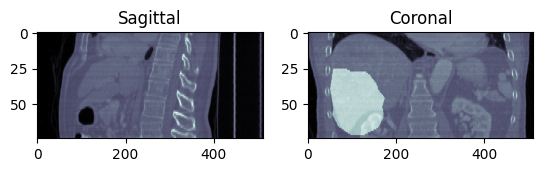

In [38]:
# Pixel dimensions in millimeters
pixel_dimensions_mm = [400, 122.5, 122.5]

# Set colormap for visualizations
colormap = "bone"

# Display median sagittal and coronal planes
fig, ax = plt.subplots(1, 2)

# Sagittal plane
ax[0].imshow(median_sagittal_plane(segmented_img_dcm), cmap=colormap, alpha=1, aspect=pixel_dimensions_mm[0] / pixel_dimensions_mm[1])
ax[0].set_title("Sagittal")

# Coronal plane
ax[1].imshow(median_coronal_plane(segmented_img_dcm), cmap=colormap, alpha=1, aspect=pixel_dimensions_mm[0] / pixel_dimensions_mm[2])
ax[1].set_title("Coronal")

plt.show()


Sagittal Planes

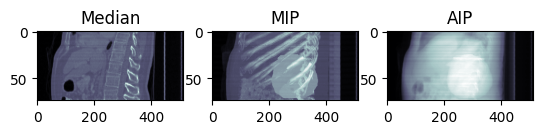

In [39]:
# Display sagittal planes based on Median/MIP/AIP methods
fig, ax = plt.subplots(1, 3)

# Median sagittal plane
ax[0].imshow(median_sagittal_plane(segmented_img_dcm), cmap=colormap, aspect=pixel_dimensions_mm[0] / pixel_dimensions_mm[1])
ax[0].set_title("Median")

# Maximum intensity projection (MIP) sagittal plane
ax[1].imshow(MIP_sagittal_plane(segmented_img_dcm), cmap=colormap, aspect=pixel_dimensions_mm[0] / pixel_dimensions_mm[1])
ax[1].set_title("MIP")

# Average intensity projection (AIP) sagittal plane
ax[2].imshow(AIP_sagittal_plane(segmented_img_dcm), cmap=colormap, aspect=pixel_dimensions_mm[0] / pixel_dimensions_mm[1])
ax[2].set_title("AIP")

plt.show()


Coronal Planes

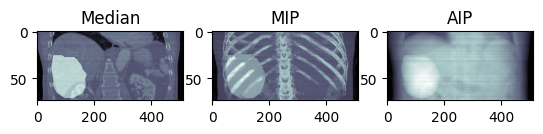

In [40]:
# Display coronal planes based on Median/MIP/AIP methods
fig, ax = plt.subplots(1, 3)

# Median coronal plane
ax[0].imshow(median_coronal_plane(segmented_img_dcm), cmap=colormap, aspect=pixel_dimensions_mm[0] / pixel_dimensions_mm[1])
ax[0].set_title("Median")

# Maximum intensity projection (MIP) coronal plane
ax[1].imshow(MIP_coronal_plane(segmented_img_dcm), cmap=colormap, aspect=pixel_dimensions_mm[0] / pixel_dimensions_mm[1])
ax[1].set_title("MIP")

# Average intensity projection (AIP) coronal plane
ax[2].imshow(AIP_coronal_plane(segmented_img_dcm), cmap=colormap, aspect=pixel_dimensions_mm[0] / pixel_dimensions_mm[1])
ax[2].set_title("AIP")

plt.show()

Creating the animation

MovieWriter ffmpeg unavailable; using Pillow instead.


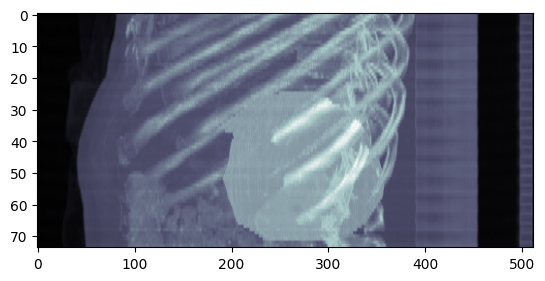

In [41]:
pixel_len_mm  =pixel_dimensions_mm

# Get the minimum and maximum pixel values from the segmented DICOM image
segmented_img_min = np.amin(segmented_img_dcm)
segmented_img_max = np.amax(segmented_img_dcm)

# Use the 'bone' colormap for visualizing the image
colormap = matplotlib.colormaps["bone"]

# Create a figure and axes for plotting
fig, ax = plt.subplots()

# Create directories if they don't exist
os.makedirs("result/", exist_ok=True)

# Define the number of rotations
num_rotations = 64

# Initialize empty lists for storing projections
segmented_img_projections = []

# Rotate the image and generate projections
for idx, angle in enumerate(np.linspace(0, 360 * (num_rotations - 1) / num_rotations, num=num_rotations)):

    # Rotate the segmented image on the axial plane
    rotated_img = rotate_on_axial_plane(segmented_img_dcm, angle)

    # Get the maximum intensity projection on the sagittal plane
    projection = MIP_sagittal_plane(rotated_img)

    # Visualize the projection
    ax.imshow(
        projection,
        cmap=colormap,
        vmin=segmented_img_min,
        vmax=segmented_img_max,
        aspect=pixel_len_mm[0] / pixel_len_mm[1],
    )

    # Save the projection as an image
    plt.savefig(f"result/Projection_{idx}.png")

    # Add the projection to the list
    segmented_img_projections.append(projection)

# Generate animation data
animation_frames = [
    [
        ax.imshow(
            projection,
            animated=True,
            cmap=colormap,
            vmin=segmented_img_min,
            vmax=segmented_img_max,
            aspect=pixel_len_mm[0] / pixel_len_mm[1],
        )
    ]
    for projection in segmented_img_projections
]

# Create an animation from the frames
animation_output = animation.ArtistAnimation(fig, animation_frames, interval=100, blit=True)

# Save the animation as a GIF
animation_output.save("result/Animation.gif")

# Show the figure
plt.show()


# Objective 2: 3D Rigid Coregistration

In [4]:
#Load Libraries
import pydicom
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import cv2
import scipy
from scipy.ndimage import zoom
from skimage import exposure

Useful functions from the lab

In [57]:
def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

def rotate_on_axial_plane_rgb(img: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """Rotate the image on the axial plane."""
    rotated_img = np.zeros_like(img)
    rotated_img[:,:] = scipy.ndimage.rotate(img[:,:], angle_in_degrees, reshape=False)
    return rotated_img

def vector_of_residuals(ref_points: np.ndarray, inp_points: np.ndarray) -> np.ndarray:
    """ Given arrays of 3D points, compute vector of residuals as their respective distance """
    distances = np.linalg.norm(inp_points - ref_points, axis=1)
    return distances

def multiply_quaternions(
        q1: tuple[float, float, float, float],
        q2: tuple[float, float, float, float]
        ) -> tuple[float, float, float, float]:
    """ Multiply two quaternions, expressed as (1, i, j, k). """
    # Your code here:
    #   ...
    return (
        q1[0] * q2[0] - q1[1] * q2[1] - q1[2] * q2[2] - q1[3] * q2[3],
        q1[0] * q2[1] + q1[1] * q2[0] + q1[2] * q2[3] - q1[3] * q2[2],
        q1[0] * q2[2] - q1[1] * q2[3] + q1[2] * q2[0] + q1[3] * q2[1],
        q1[0] * q2[3] + q1[1] * q2[2] - q1[2] * q2[1] + q1[3] * q2[0]
    )

def conjugate_quaternion(
        q: tuple[float, float, float, float]
        ) -> tuple[float, float, float, float]:
    """ Multiply two quaternions, expressed as (1, i, j, k). """
    # Your code here:
    #   ...
    return (
        q[0], -q[1], -q[2], -q[3]
    )

def translation(
        point: tuple[float, float, float],
        translation_vector: tuple[float, float, float]
        ) -> tuple[float, float, float]:
    """ Perform translation of `point` by `translation_vector`. """
    x, y, z = point
    v1, v2, v3 = translation_vector
    # Your code here
    # ...
    return (x+v1, y+v2, z+v3)

def axial_rotation(
        point: tuple[float, float, float],
        angle_in_rads: float,
        axis_of_rotation: tuple[float, float, float]) -> tuple[float, float, float]:
    """ Perform axial rotation of `point` around `axis_of_rotation` by `angle_in_rads`. """
    x, y, z = point
    v1, v2, v3 = axis_of_rotation
    # Normalize axis of rotation to avoid restrictions on optimizer
    v_norm = math.sqrt(sum([coord ** 2 for coord in [v1, v2, v3]]))
    v1, v2, v3 = v1 / v_norm, v2 / v_norm, v3 / v_norm
    # Your code here:
    #   ...
    #   Quaternion associated to point.
    p = (0, x, y, z)
    #   Quaternion associated to axial rotation.
    cos, sin = math.cos(angle_in_rads / 2), math.sin(angle_in_rads / 2)
    q = (cos, sin * v1, sin * v2, sin * v3)
    #   Quaternion associated to image point
    q_star = conjugate_quaternion(q)
    p_prime = multiply_quaternions(q, multiply_quaternions(p, q_star))
    #   Interpret as 3D point (i.e. drop first coordinate)
    return p_prime[1], p_prime[2], p_prime[3]

def translation_then_axialrotation(point: tuple[float, float, float], parameters: tuple[float, ...]):
    """ Apply to `point` a translation followed by an axial rotation, both defined by `parameters`. """
    x, y, z = point
    t1, t2, t3, angle_in_rads, v1, v2, v3 = parameters
    # Normalize axis of rotation to avoid restrictions on optimizer
    v_norm = math.sqrt(sum([coord ** 2 for coord in [v1, v2, v3]]))
    v1, v2, v3 = v1/v_norm, v2/v_norm, v3/v_norm
    # Your code here:
    #   ...
    x, y, z = translation(point=(x, y, z), translation_vector=(t1, t2, t3))
    x, y, z = axial_rotation(point=(x, y, z), angle_in_rads=angle_in_rads, axis_of_rotation=(v1, v2, v3))
    return x, y, z

def find_centroid(mask: np.ndarray) -> np.ndarray:
    # Your code here:
    #   Consider using `np.where` to find the indices of the voxels in the mask
    #   ...
    idcs = np.where(mask == 1)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid

def coregister_landmarks(ref_landmarks: np.ndarray, inp_landmarks: np.ndarray):
    """ Coregister two sets of landmarks using a rigid transformation. """
    initial_parameters = [
        0, 0, 0,    # Translation vector
        0,          # Angle in rads
        1, 0, 0,    # Axis of rotation
    ]
    # Find better initial parameters
    centroid_ref = np.mean(ref_landmarks, axis=0)
    centroid_inp = np.mean(inp_landmarks, axis=0)
    # Your code here:
    #   ...
    initial_parameters[0] = centroid_ref[0] - centroid_inp[0]
    initial_parameters[1] = centroid_ref[1] - centroid_inp[1]
    initial_parameters[2] = centroid_ref[2] - centroid_inp[2]

    def function_to_minimize(parameters):
        """ Transform input landmarks, then compare with reference landmarks."""
        # Your code here:
        #   ...
        inp_landmarks_transf = np.asarray([translation_then_axialrotation(point, parameters)
                                           for point in inp_landmarks])
        return vector_of_residuals(ref_landmarks, inp_landmarks_transf)

    # Apply least squares optimization
    result = least_squares(
        function_to_minimize,
        x0=initial_parameters,
        verbose=1)
    return result

In [58]:
# Load reference DICOM file and extract pixel array
reference_dcm = pydicom.dcmread('./Objective_2/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm')
reference_images = reference_dcm.pixel_array

# Load AAL3 dicom and extract pixel array
seg_dcm = pydicom.dcmread("./Objective_2/AAL3_1mm.dcm")
segmentation = seg_dcm.pixel_array

# Define directory containing DICOM files
directory = "./Objective_2/RM_Brain_3D-SPGR"

# Get sorted list of file names in the directory
sorted_directory = sorted(os.listdir(directory))

# Create dictionary to store instances
instances = {}

# Iterate over the files in the directory
for f_name in sorted_directory:
    if f_name.endswith(".dcm"):
        path = os.path.join(directory, f_name)
        dataset = pydicom.dcmread(path)
        instance_number = dataset.InstanceNumber
        instances[instance_number] = path

# Sort the instances based on instance number
sorted_instances = sorted(instances.items(), key=lambda x: x[0])

# Extract sorted paths from sorted instances
sorted_paths = [path for _, path in sorted_instances]

# Create list to store pixel data
input_images = []

# Iterate over sorted paths and extract pixel arrays
for path in sorted_paths:
    dataset = pydicom.dcmread(path)
    input_images.append(np.flip(dataset.pixel_array, axis=0))


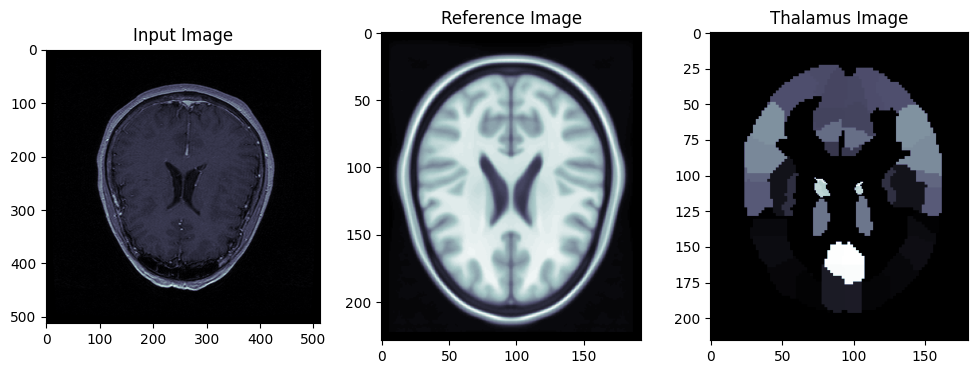

In [140]:
# Convert input_images, reference_images, and aal to numpy arrays
volume = np.stack(input_images, axis=0)
volume_ref = np.stack(reference_images, axis=0)
volume_aal = np.stack(segmentation, axis=0)

# Calculate the index of the middle plane for each volume
# 106th image
plane_index = volume.shape[0] // 2
plane_index_ref = volume_ref.shape[0] // 2
plane_index_aal = volume_aal.shape[0] // 2

# Extract horizontal planes from each volume
horizontal_plane = volume[plane_index + 15, :, :]
horizontal_plane_ref = volume_ref[plane_index_ref, :, :]
horizontal_plane_aal = volume_aal[plane_index_aal, :, :]

# Create a figure with 1 row and 3 columns for the subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Create a list of images and titles for the horizontal planes
images = [horizontal_plane, horizontal_plane_ref, horizontal_plane_aal]
titles = ["Input Image", "Reference Image", "Thalamus Image"]

# Iterate over the images and titles and plot them in the subplots
for i in range(3):
    ax[i].imshow(images[i], cmap='bone')
    ax[i].set_title(titles[i])

# Display the figure
plt.show()


In [60]:
plane_index

106

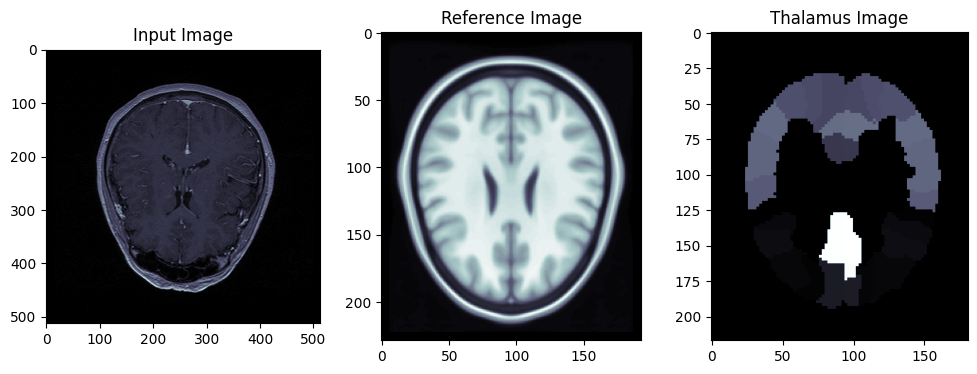

In [61]:
# Convert input_images, reference_images, and aal to numpy arrays
volume = np.stack(input_images, axis=0)
volume_ref = np.stack(reference_images, axis=0)
volume_aal = np.stack(segmentation, axis=0)

# Getting the 100th image for example visualization
index = 100

# Extract horizontal planes from each volume
horizontal_plane = volume[index + 15, :, :]
horizontal_plane_ref = volume_ref[index, :, :]
horizontal_plane_aal = volume_aal[index, :, :]

# Create a figure with 1 row and 3 columns for the subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Create a list of images and titles for the horizontal planes
images = [horizontal_plane, horizontal_plane_ref, horizontal_plane_aal]
titles = ["Input Image", "Reference Image", "Thalamus Image"]

# Iterate over the images and titles and plot them in the subplots
for i in range(3):
    ax[i].imshow(images[i], cmap='bone')
    ax[i].set_title(titles[i])

# Display the figure
plt.show()


In [62]:
def preprocess_landmarks(landmarks):
    normalized_landmarks = landmarks / np.max(landmarks)
    preprocessed_landmarks = np.round(normalized_landmarks, 2) * 100
    return preprocessed_landmarks.astype(int)

In [63]:
def get_thalamus_mask(img_atlas: np.ndarray) -> np.ndarray:
    thalamus_mask = np.zeros_like(img_atlas)
    thalamus_mask[(121 <= img_atlas) & (img_atlas <= 150)] = 1
    return thalamus_mask


In [64]:
# Reshape 
img_phantom = reference_dcm.pixel_array[6:-6, 6:-7, 6:-6]     # Crop phantom to match the AAL size
segmentation = segmentation[:, :-1, :] 

# Generate thalamus mask based on the AAL segmentation
thalamus_mask = get_thalamus_mask(segmentation)
mask_centroid = find_centroid(thalamus_mask)
mask_centroid_idx = mask_centroid[0].astype('int')

# Reshape the input data 
input_data = np.array(input_images)
z_start = (input_data.shape[0] - 181) + 3  # Adjust the starting index based on the mask
cropped_data = input_data[z_start:z_start + 181, 48:456, 83:438]  # Crop the input data

resize_factors = (181 / cropped_data.shape[0], 216 / cropped_data.shape[1], 181 / cropped_data.shape[2])
resized_data = zoom(cropped_data, resize_factors, order=1)  # Resize the cropped data
rotated_data = rotate_on_axial_plane(resized_data, 2)  # Rotate the data on the axial plane
processed_input = preprocess_landmarks(rotated_data)  # Preprocess the input data

Preprocessing input data and referance data to match with mask

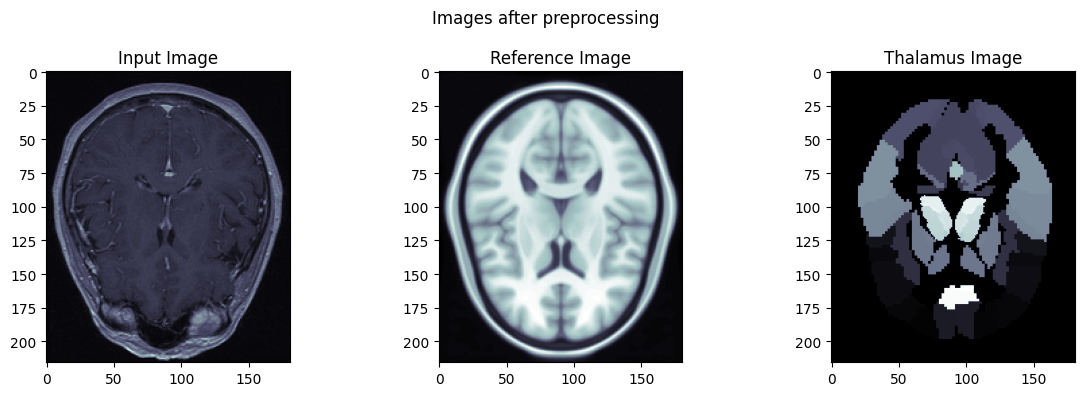

In [65]:
# Preprocessing visualization
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Create a list of images and titles for the visualization
images = [processed_input[mask_centroid_idx], img_phantom[mask_centroid_idx], segmentation[mask_centroid_idx]]
titles = ["Input Image", "Reference Image", "Thalamus Image"]

# Iterate over the images and titles and plot them in the subplots
for i in range(3):
    ax[i].imshow(images[i], cmap='bone')
    ax[i].set_title(titles[i])

# Add a common title for the figure
fig.suptitle("Images after preprocessing")

# Adjust the spacing between subplots
fig.tight_layout()

# Display the figure
plt.show()


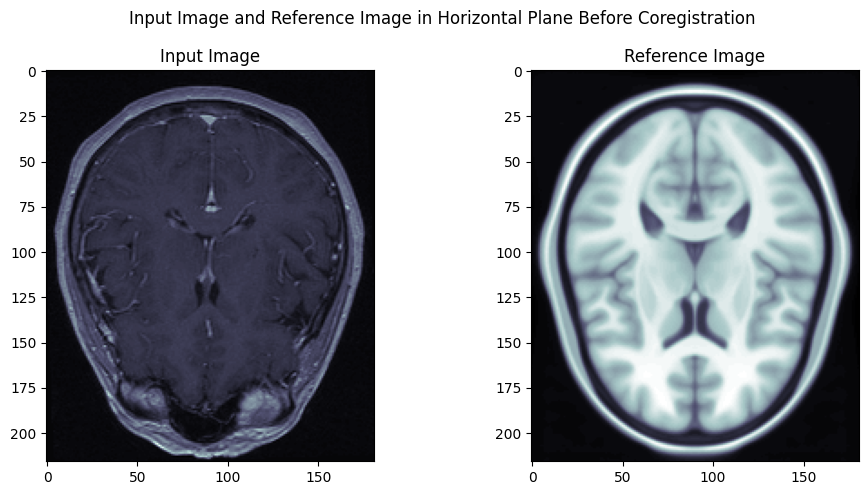

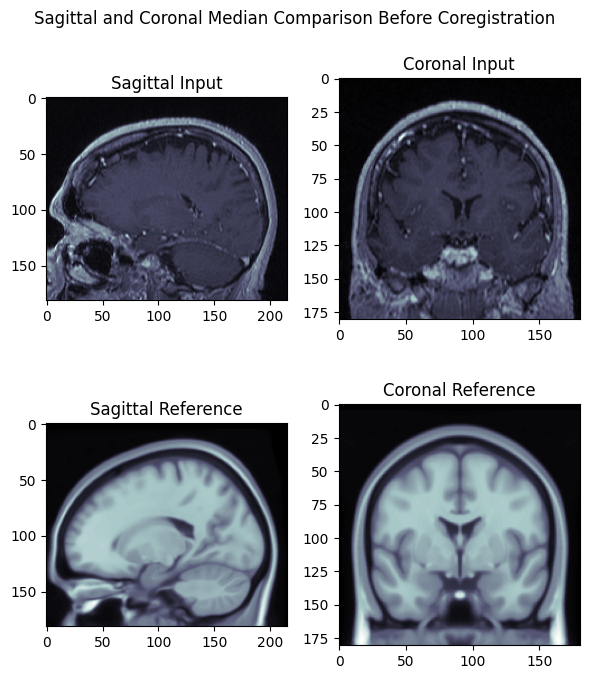

In [66]:
# Create a figure with 1 row and 2 columns for the subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Create a list of images and titles for input and reference images
images = [processed_input[mask_centroid_idx], img_phantom[mask_centroid_idx]]
titles = ["Input Image", "Reference Image"]

# Iterate over the images and titles and plot them in the subplots
for i in range(2):
    ax[i].imshow(images[i], cmap='bone')
    ax[i].set_title(titles[i])

# Add a common title for the figure
fig.suptitle("Input Image and Reference Image in Horizontal Plane Before Coregistration")

# Adjust the spacing between subplots
fig.tight_layout()

# Display the figure
plt.show()

In [ ]:
# Define the sagittal and coronal planes for input, reference, and segmentation images
input_sagittal = median_sagittal_plane(np.flip(inp_landmarks_orig))
input_coronal = median_coronal_plane(np.flip(inp_landmarks_orig))
reference_sagittal = median_sagittal_plane(np.flip(img_phantom))
reference_coronal = median_coronal_plane(np.flip(img_phantom))
segmentation_sagittal = median_sagittal_plane(np.flip(segmentation))
segmentation_coronal = median_coronal_plane(np.flip(segmentation))

# Create a list of images and titles for the subplots
images = [
    input_sagittal,
    input_coronal,
    reference_sagittal,
    reference_coronal,
    segmentation_sagittal,
    segmentation_coronal
]
titles = [
    "Sagittal Input",
    "Coronal Input",
    "Sagittal Reference",
    "Coronal Reference",
    "Sagittal Segmentation",
    "Coronal Segmentation"
]

# Create a figure with 3 rows and 2 columns for the subplots
fig, ax = plt.subplots(3, 2, figsize=(8, 10))

# Iterate over the images and titles and plot them in the subplots
for ax, image, title in zip(ax.flatten(), images, titles):
    ax.imshow(image, cmap='bone')
    ax.set_title(title)
    ax.axis('off')

# Add a common title for the figure
fig.suptitle("Sagittal and Coronal Median Comparison After Coregistration", fontsize=14, fontweight='bold')

# Adjust the spacing between subplots
fig.tight_layout(pad=1.5)

# Display the figure
plt.show()


In [67]:
ds_ref = img_phantom[::4, ::4, ::4].reshape(-1,3)
ds_input = processed_input[::4, ::4, ::4].reshape(-1,3)
ref_landmarks = img_phantom.reshape(-1, 3)
inp_landmarks = processed_input.reshape(-1, 3)
vec = vector_of_residuals(ref_landmarks, inp_landmarks)
print(f'Mean residual value: {np.mean(vec.flatten())}.')

Mean residual value: 23.891182965471263.


Landmark Visualization Before Coregistration

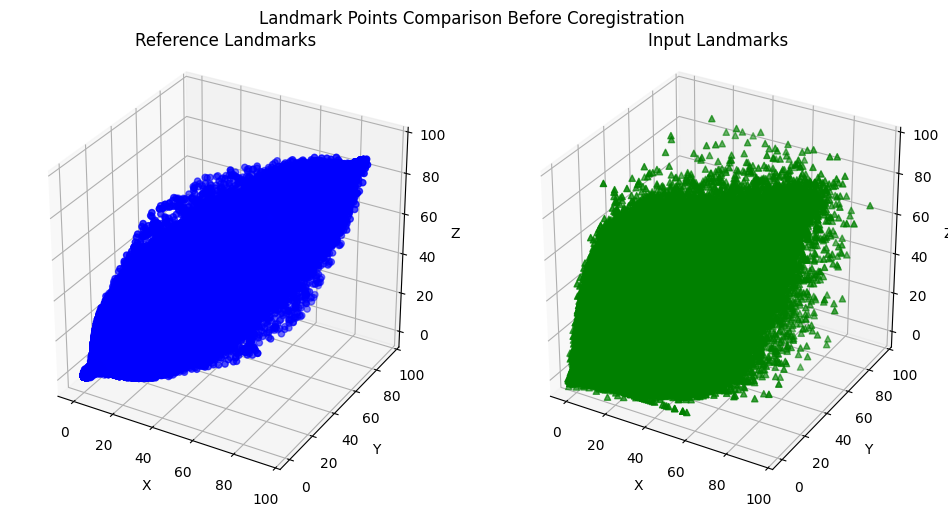

In [68]:
from mpl_toolkits.mplot3d import Axes3D

# Set the size of the figure
fig = plt.figure(figsize=(10, 5))

limit = inp_landmarks.shape[0]
ref_show = ref_landmarks[:limit]
inp_show = inp_landmarks[:limit]

# Create two subplots for reference and input landmarks
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot reference landmarks
ax1.scatter(ref_show[..., 0], ref_show[..., 1], ref_show[..., 2], marker='o', color='blue')
ax1.set_title('Reference Landmarks')

# Plot input landmarks
ax2.scatter(inp_show[..., 0], inp_show[..., 1], inp_show[..., 2], marker='^', color='green')
ax2.set_title('Input Landmarks')

# Set equal aspect ratio for all axes
for ax in [ax1, ax2]:
    ax.set_box_aspect([1, 1, 1])

# Set common axis limits
all_points = np.concatenate([ref_show, inp_show], axis=0)
min_val = np.min(all_points)
max_val = np.max(all_points)
ax1.set_xlim3d(min_val, max_val)
ax1.set_ylim3d(min_val, max_val)
ax1.set_zlim3d(min_val, max_val)
ax2.set_xlim3d(min_val, max_val)
ax2.set_ylim3d(min_val, max_val)
ax2.set_zlim3d(min_val, max_val)

# Set labels for the axes
for ax in [ax1, ax2]:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Set title for the figure
fig.suptitle("Landmark Points Comparison Before Coregistration")

# Adjust spacing between subplots
fig.tight_layout()

# Display the figure
plt.show()


In [15]:
# Coregister landmarks
print("Coregistering the landmarks...")
result = coregister_landmarks(ds_ref[:limit], ds_input[:limit]) # 30 mins with downsampling
solution_found = result.x

t1, t2, t3, angle_in_rads, v1, v2, v3 = result.x
best_params = result.x

print('Best parameters:')
print(f'  >> Translation: ({t1:0.02f}, {t2:0.02f}, {t3:0.02f}).')
print(f'  >> Rotation: {angle_in_rads:0.02f} rads around axis ({v1:0.02f}, {v2:0.02f}, {v3:0.02f}).')


Coregistering the landmarks...
The maximum number of function evaluations is exceeded.
Function evaluations 700, initial cost 1.7039e+07, final cost 1.7035e+07, first-order optimality 1.37e+04.
Best parameters:
  >> Translation: (9.15, 9.38, 8.92).
  >> Rotation: 0.02 rads around axis (0.98, 0.02, 0.21).


In [69]:
best_params

array([9.15107286, 9.38467265, 8.92191211, 0.0160967 , 0.97691136,
       0.02074594, 0.21295392])

Landmark Visualization After Coregistration

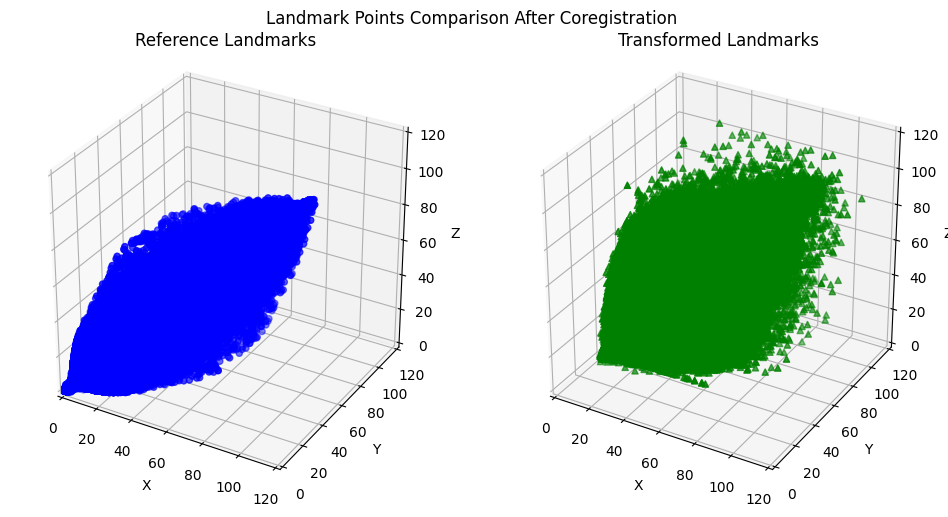

In [49]:
# Apply transformations to input landmarks
inp_landmarks[:] = np.asarray([translation_then_axialrotation(point, best_params) for point in inp_landmarks[:]])

# Create a figure
fig = plt.figure(figsize=(10, 5))

# Create two subplots for reference and transformed landmarks
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot reference landmarks
ax1.scatter(ref_show[..., 0], ref_show[..., 1], ref_show[..., 2], marker='o', color='blue')
ax1.set_title('Reference Landmarks')

# Plot transformed landmarks
ax2.scatter(inp_show[..., 0], inp_show[..., 1], inp_show[..., 2], marker='^', color='green')
ax2.set_title('Transformed Landmarks')

# Set equal aspect ratio for all axes
for ax in [ax1, ax2]:
    ax.set_box_aspect([1, 1, 1])

# Set common axis limits
all_points = np.concatenate([ref_show, inp_show], axis=0)
min_val = np.min(all_points)
max_val = np.max(all_points)
ax1.set_xlim3d(min_val, max_val)
ax1.set_ylim3d(min_val, max_val)
ax1.set_zlim3d(min_val, max_val)
ax2.set_xlim3d(min_val, max_val)
ax2.set_ylim3d(min_val, max_val)
ax2.set_zlim3d(min_val, max_val)

# Set labels for the axes
for ax in [ax1, ax2]:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Set title for the figure
fig.suptitle("Landmark Points Comparison After Coregistration")

# Adjust spacing between subplots
fig.tight_layout()

# Display the figure
plt.show()


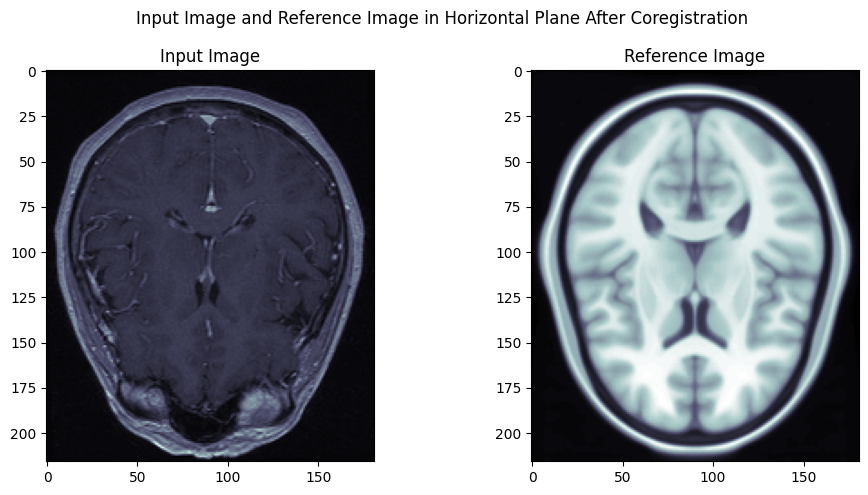

In [128]:
# Create a figure with 1 row and 2 columns for the subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

inp_landmarks_orig = inp_landmarks.reshape(181, 216, 181)

# Create a list of images and titles for input and reference images
images = [inp_landmarks_orig[mask_centroid_idx], img_phantom[mask_centroid_idx]]
titles = ["Input Image", "Reference Image"]

# Iterate over the images and titles and plot them in the subplots
for i in range(2):
    ax[i].imshow(images[i], cmap='bone')
    ax[i].set_title(titles[i])

# Add a common title for the figure
fig.suptitle("Input Image and Reference Image in Horizontal Plane After Coregistration")

# Adjust the spacing between subplots
fig.tight_layout()

# Display the figure
plt.show()

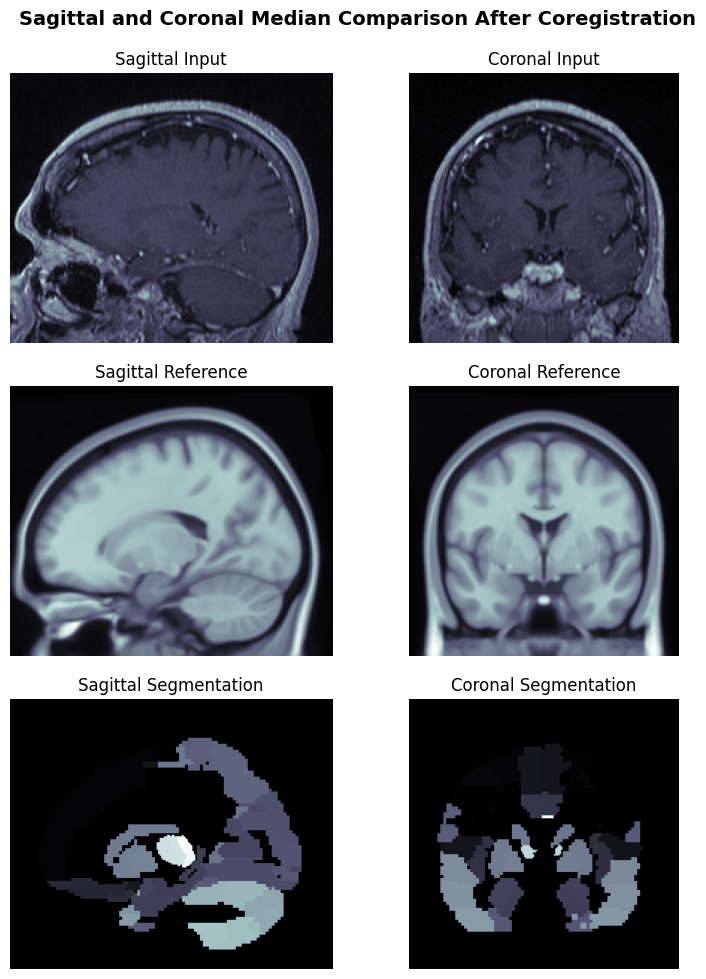

In [129]:
# Define the sagittal and coronal planes for input, reference, and segmentation images
input_sagittal = median_sagittal_plane(np.flip(inp_landmarks_orig))
input_coronal = median_coronal_plane(np.flip(inp_landmarks_orig))
reference_sagittal = median_sagittal_plane(np.flip(img_phantom))
reference_coronal = median_coronal_plane(np.flip(img_phantom))
segmentation_sagittal = median_sagittal_plane(np.flip(segmentation))
segmentation_coronal = median_coronal_plane(np.flip(segmentation))

# Create a list of images and titles for the subplots
images = [
    input_sagittal,
    input_coronal,
    reference_sagittal,
    reference_coronal,
    segmentation_sagittal,
    segmentation_coronal
]
titles = [
    "Sagittal Input",
    "Coronal Input",
    "Sagittal Reference",
    "Coronal Reference",
    "Sagittal Segmentation",
    "Coronal Segmentation"
]

# Create a figure with 3 rows and 2 columns for the subplots
fig, ax = plt.subplots(3, 2, figsize=(8, 10))

# Iterate over the images and titles and plot them in the subplots
for ax, image, title in zip(ax.flatten(), images, titles):
    ax.imshow(image, cmap='bone')
    ax.set_title(title)
    ax.axis('off')

# Add a common title for the figure
fig.suptitle("Sagittal and Coronal Median Comparison After Coregistration", fontsize=14, fontweight='bold')

# Adjust the spacing between subplots
fig.tight_layout(pad=1.5)

# Display the figure
plt.show()


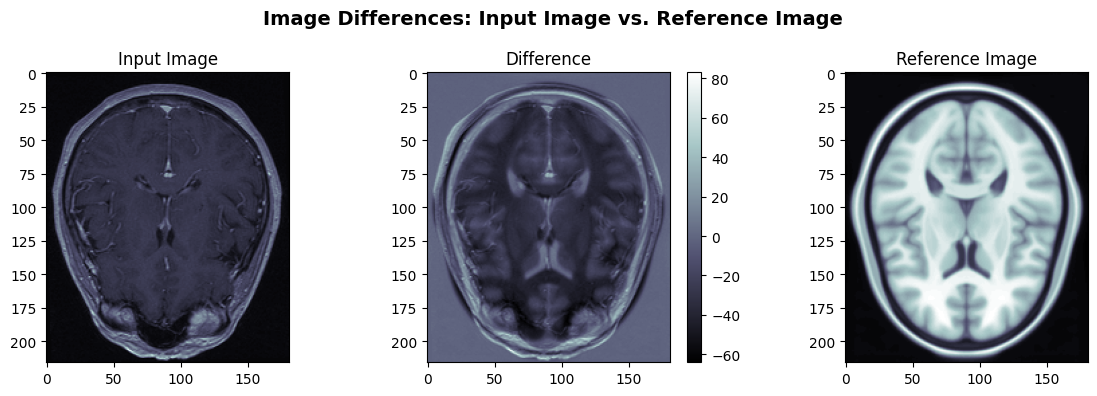

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Stack the input landmarks to create a volume
volume = np.stack(inp_landmarks_orig, axis=0)

# Stack the phantom images to create a reference volume
volume_ref = np.stack(img_phantom, axis=0)

# Stack the segmentations to create a volume for analysis
volume_aal = np.stack(segmentation, axis=0)

# Determine the index of the central plane in each volume
plane_index = volume.shape[0] // 2
plane_index_ref = volume_ref.shape[0] // 2
plane_index_aal = volume_aal.shape[0] // 2

# Visualize the difference between the reference and original images
img_orig = inp_landmarks_orig[mask_centroid_idx, :, :]
img_ref = img_phantom[mask_centroid_idx, :, :]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img_orig, cmap='bone')
axs[0].set_title('Input Image')

diff_img = img_orig - img_ref
im = axs[1].imshow(diff_img, cmap='bone')
axs[1].set_title('Difference')
fig.colorbar(im, ax=axs[1])

axs[2].imshow(img_ref, cmap='bone')
axs[2].set_title('Reference Image')

fig.suptitle("Image Differences: Input Image vs. Reference Image", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [72]:
def mean_absolute_error(img_input: np.ndarray, img_reference) -> np.ndarray:
    """ Compute the MAE between two images. """
    return np.mean(np.abs(img_input - img_reference))


def mean_squared_error(img_input: np.ndarray, img_reference) -> np.ndarray:
    """ Compute the MSE between two images. """
    return np.mean((img_input - img_reference)**2)


def mutual_information(img_input: np.ndarray, img_reference) -> np.ndarray:
    """ Compute the Shannon Mutual Information between two images. """
    nbins = [10, 10]
    # Compute entropy of each image
    hist = np.histogram(img_input.ravel(), bins=nbins[0])[0]
    prob_distr = hist / np.sum(hist)
    entropy_input = -np.sum(prob_distr * np.log2(prob_distr + 1e-7))  # Why +1e-7?
    hist = np.histogram(img_reference.ravel(), bins=nbins[0])[0]
    prob_distr = hist / np.sum(hist)
    entropy_reference = -np.sum(prob_distr * np.log2(prob_distr + 1e-7))  # Why +1e-7?
    # Compute joint entropy
    joint_hist = np.histogram2d(img_input.ravel(), img_reference.ravel(), bins=nbins)[0]
    prob_distr = joint_hist / np.sum(joint_hist)
    joint_entropy = -np.sum(prob_distr * np.log2(prob_distr + 1e-7))
    # Compute mutual information
    return entropy_input + entropy_reference - joint_entropy

In [53]:
# Compute metrics
mae = mean_absolute_error(img_ref, img_orig)
mse = mean_squared_error(img_ref, img_orig)
mutual_inf = mutual_information(img_ref, img_orig)

# Print metrics
print('Mean Absolute Error (MAE):')
print('  Result:', '{:.02f} HU'.format(mae))

print('Mean Squared Error (MSE):')
print('  Result:', '{:.02f} HU^2'.format(mse))

print('Mutual Information:')
print('  Result:', '{:.02f} bits'.format(mutual_inf))


Mean Absolute Error (MAE):
  Result: 16.18 HU
Mean Squared Error (MSE):
  Result: 342.57 HU^2
Mutual Information:
  Result: 0.65 bits


# Thalamus

In [119]:
def visualize_axial_slice(img: np.ndarray, mask: np.ndarray, mask_centroid: np.ndarray) -> np.ndarray:
    """ Visualize the axial slice (first dimension) of a single region with alpha fusion. """
    fused_slices = []
    
    for i in range(img.shape[0]):
        cmap = plt.get_cmap('bone')
        norm = matplotlib.colors.Normalize(vmin=np.amin(img[i]), vmax=np.amax(img[i]))
        fused_slice = (
            0.6 * cmap(norm(img[i]))[..., :3] +
            0.4 * np.stack([mask[i], np.zeros_like(mask[i]), np.zeros_like(mask[i])], axis=-1)
        )
        
        fused_slices.append(fused_slice[..., 0])
    
    return np.array(fused_slices)

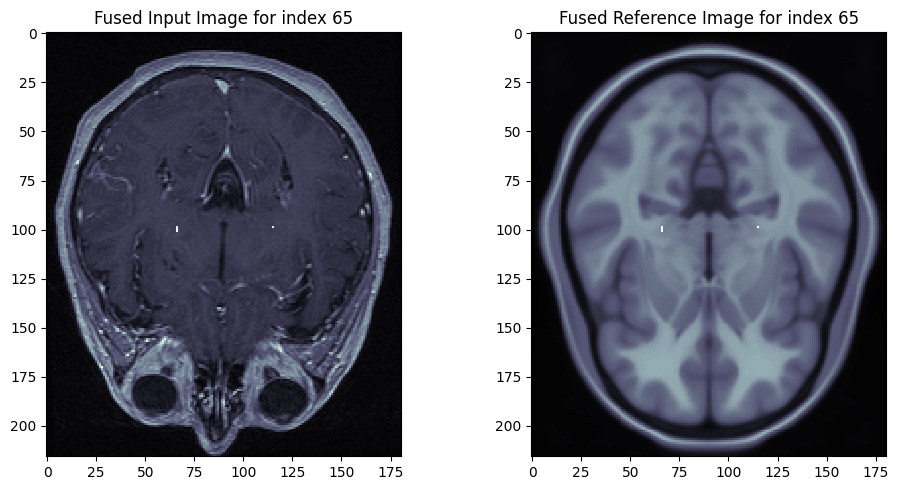

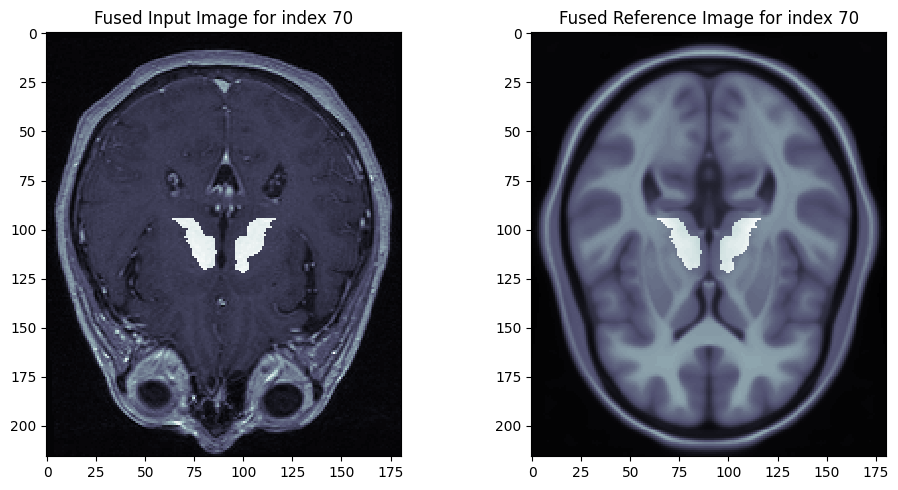

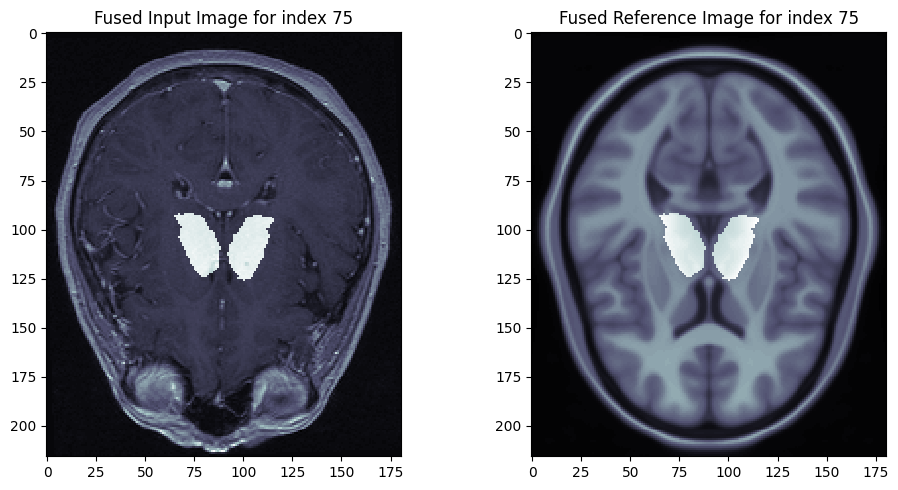

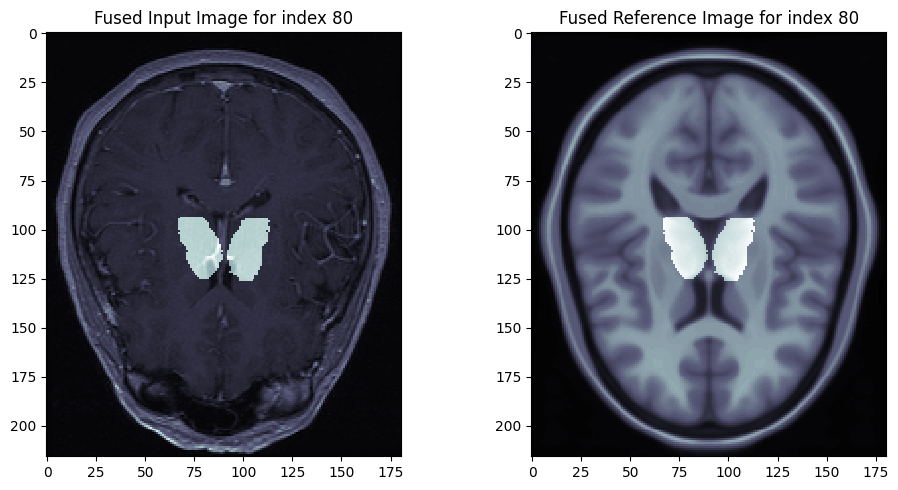

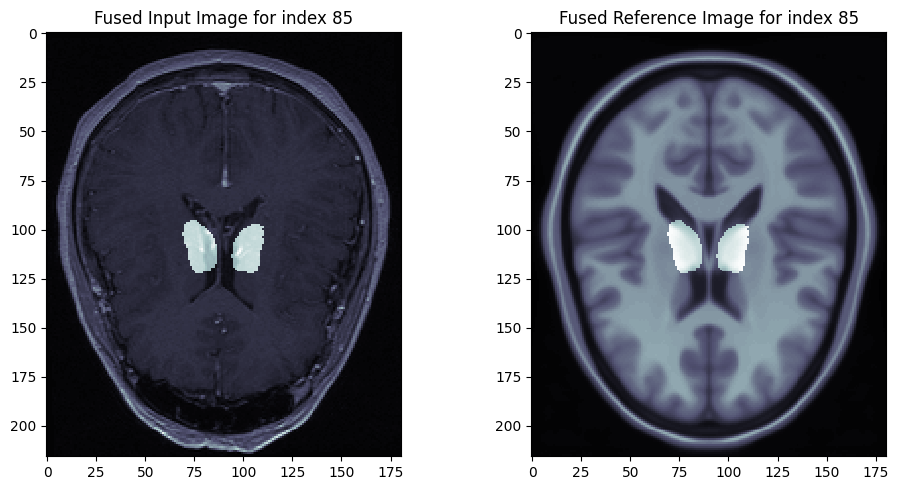

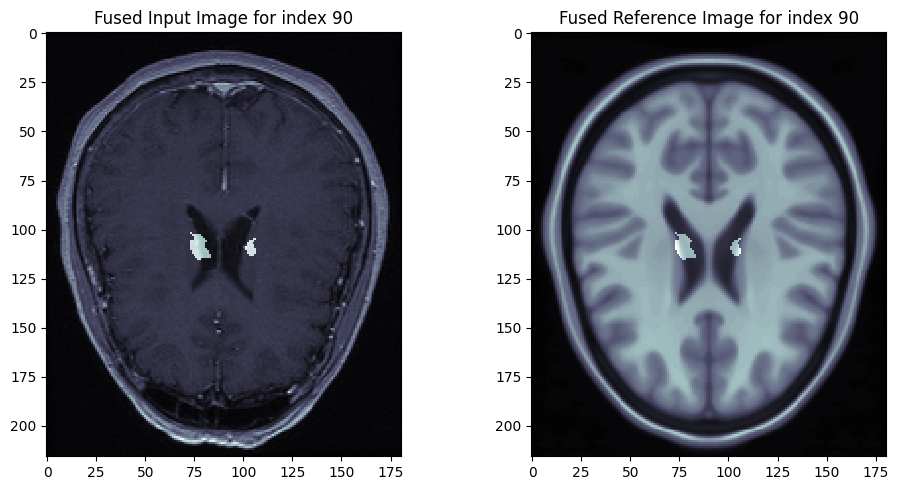

In [150]:
# Generate fused phantom image
fused_phantom = visualize_axial_slice(img_phantom, thalamus_mask, mask_centroid)
# Generate fused original image
fused_orig = visualize_axial_slice(inp_landmarks_orig, thalamus_mask, mask_centroid)

# Display fused images for specific indices
indices = range(65, 91, 5)
for i in indices:
    # Display fused images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(fused_orig[i], cmap='bone', interpolation='nearest')
    axs[0].set_title(f"Fused Input Image for index {i}")
    axs[1].imshow(fused_phantom[i], cmap='bone', interpolation='nearest')
    axs[1].set_title(f"Fused Reference Image for index {i}")
    plt.tight_layout()
    plt.show()